# Process and map range of trigger thresholds

NB: to make multi-model NMME processing work, gotta set the boostrap draws to only non-nan values

In [1]:
import xarray as xr
from xarray.groupers import SeasonResampler
import xesmf as xe
import numpy as np
import pandas as pd 
import geopandas as gpd
import os
import glob
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import matplotlib as mpl
from cartopy import crs as ccrs
import cmocean
from dask.diagnostics import ProgressBar
from numba import jit as njit
from distributed import Client

from funcs_support import get_params,get_filepaths, utility_print, utility_save
from funcs_aux import get_landmask

dir_list = get_params()

In [2]:
client = Client()
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 503.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35380,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39839,Total threads: 6
Dashboard: http://127.0.0.1:39294/status,Memory: 62.92 GiB
Nanny: tcp://127.0.0.1:36493,


2026-02-02 11:18:02,490 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:41926'.
2026-02-02 11:18:02,619 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:44440'.
2026-02-02 11:18:02,708 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:44641'.
2026-02-02 11:18:02,789 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:42033'.
2026-02-02 11:18:02,792 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39839'.
2026-02-02 11:18:02,794 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:46602'.
2026-02-02 11:18:02,796 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:44921'.
2026-02-02 11:18:02,797 - distributed.scheduler - WARNING - Received heartbeat from unregistered 

## Setup

In [3]:
# Trigger threshold
aa_trigger = 0.2
# Random seed for bootstraps
rng = np.random.default_rng()
# How many years / block
samp_size = 5
# How many bootstrap draws
ndraws = 1000

# Set up filepaths
df = get_filepaths()

# Which data to use
# GPCP, CHIRPS, or NMME
proc_source = 'GPCP' 

# Set output filenames
output_fns = {'threshs':dir_list['tmp']+'pr-trigger-threshs_year_'+proc_source+'.zarr',
              'seasmask':dir_list['aux']+'seasmask_CHIRPS.zarr'}

## Helper functions

In [4]:
def load_data(proc_source):
    if proc_source == 'GPCP':
        #----- For GPCP ----- 
        df_tmp = df.query('model == "GPCP"')
        fn = df_tmp.iloc[0]['path']
        ds = xr.open_dataset(fn)
        
    elif proc_source == 'CHIRPS':
        #----- For CHIRPS ----- 
        df_tmp = df.query('model == "CHIRPS" and freq == "Amon"')
        fn = df_tmp.iloc[0]['path']
        ds = xr.open_dataset(fn,chunks = {'lat':20,'lon':20,'time':-1})
    
    elif proc_source == 'NMME':
        #----- For NMME -----
        # Will require setting model explicilty in figure code
        # AND will require changing bootstrap code to only sample from non-nan chunks
        df_tmp = df.query('exp == "hindcasts"')
        ds = xr.concat([xr.open_dataset(row[1]['path'],chunks={'lat':20,'lon':50})
                        for row in df_tmp.iterrows()],
                       dim=pd.Index([row[1]['model'] for row in df_tmp.iterrows()],
                                                   name='model'),
                        join='outer')
    return ds

@njit
def get_boot_threshs(da, start_years, aa_trigger=aa_trigger, samp_size=samp_size):
    ''' Numabized bootstrap thresholds '''
    
    # Make sure the input_core_dims order matches this
    n_run = start_years.shape[0]
    n_block = start_years.shape[1]

    threshs = np.empty(n_run, dtype=da.dtype)

    # For each bootstrap run, generate moving blocks
    for run_idx in range(n_run):
        # Preallocate draws: (blocks × samp_size)
        draws = np.empty((n_block, samp_size), dtype=da.dtype)

        for b in range(n_block):
            sy = start_years[run_idx, b]
            draws[b, :] = da[sy:sy + samp_size]

        threshs[run_idx] = np.quantile(draws, aa_trigger)

    return threshs

## Calculate trigger thresholds

In [5]:
if not os.path.exists(output_fns['threshs']):
    # Load data
    ds = load_data(proc_source)
    
    #-------------------------
    # Get seasonal means
    #-------------------------
    dsm = ds.groupby(
        time=SeasonResampler(["DJF", "MAM", "JJA", "SON"], drop_incomplete=True)
    ).mean()
    
    # Unstack into season x year
    dsm['season'] = dsm.time.dt.season
    dsm['year'] = dsm.time.dt.year
    dsm = dsm.set_index(time=['season','year']).unstack()

    dsm = dsm.chunk({'time':-1,'lat':250,'lon':250})
    
    #with ProgressBar():
    #    dsm = dsm.compute()

    #-------------------------
    # Calculate triggers for each bootstrap run 
    #-------------------------
    # Generate starting years of bootstrap blocks
    start_years = xr.DataArray(rng.integers(0,dsm.sizes['year'] - samp_size,
                               (ndraws,np.ceil(dsm.sizes['year']/samp_size).astype(int))),
                               dims=['draw','block'])

    # Get triggers for each block bootstrap time series draw
    threshs =  xr.apply_ufunc(get_boot_threshs,
                               dsm.pr,
                               start_years,
                               input_core_dims = [['year'],['draw','block']],
                               output_core_dims = [['draw']],
                               vectorize=True,
                               dask = 'parallelized')
    threshs = threshs.to_dataset(name='triggthresh')

    #-------------------------
    # Calculate stats of triggers across bootstrap runs 
    #-------------------------
    # Get range of threshholds
    threshs['triggiqr'] = threshs['triggthresh'].quantile(0.975,dim='draw') - threshs['triggthresh'].quantile(0.025,dim='draw')
    threshs['triggiqr'].attrs['long_name'] = '95% IQR of trigger thresholds across runs'
    
    # Get means for reference
    threshs['threshmean'] = threshs['triggthresh'].mean('draw')
    threshs['threshmean'].attrs['long_name'] = 'Mean of trigger thresholds across runs'
    
    # Get IQR / mean precipitation
    threshs['triggiqr_cv_meanpr'] = (threshs['triggiqr'] / dsm.pr.mean('year'))
    threshs['triggiqr_cv_meanpr'].attrs['long_name'] = 'Ratio of 95% IQR of trigger thresholds to mean rainfall'
    
    # IQR / mean trigger
    threshs['triggiqr_cv'] = threshs['triggiqr'] / threshs['triggthresh'].mean('draw')
    threshs['triggiqr_cv'].attrs['long_name'] = 'Ratio of 95% IQR of trigger thresholds to mean trigger threshold'
    
    # And log version of the same
    threshs['triggiqr_cv_log'] = np.log(threshs['triggiqr'])
    threshs['triggiqr_cv_log'].attrs['long_name'] = 'Log ratio of 95% IQR of trigger thresholds to mean trigger threshold'

    #-------------------------
    # Output temporary file 
    #-------------------------
    threshs = threshs.assign_coords({'aa_thresh':([],aa_trigger)})
    threshs.attrs['SOURCE'] = 'map_thresh.ipynb'
    threshs.attrs['DESCRIPTION'] = 'AA trigger thresholds for moving-block bootstrap runs'
    threshs.attrs['nblocks'] = ndraws
    threshs.attrs['years_per_block'] = samp_size

    

    utility_save(threshs.drop_encoding,output_fns['threshs'])
else:
    threshs = xr.open_zarr(output_fns['threshs']).load()
    print(output_fns['threshs']+' exists, loaded!')

/dx06/data/aux_joint/pr-trigger-threshs_year_GPCP.zarr exists, loaded!


## Plot figures

In [7]:
# Get landmask
landmask = get_landmask(threshs,lm_source='ne110')

# Get country borders
gdf = gpd.read_file(dir_list['aux']+'geo_data/ne_10m_admin_0_countries_iso/ne_10m_admin_0_countries_iso.shp')

lat/lon bounds not found in dataset; they will be created.


In [8]:
## TRANSFER SEASONAL THRESHOLDS INTO A SEASONAL MASK 
# using CHIRPS
if not os.path.exists(output_fns['seasmask']):
    # Load seasonal thresholds
    ds_seas = xr.open_zarr(dir_list['proc']+'CHIRPS/prseasstats_doyavg_CHIRPS_historical_obs_1981010101-20250930.zarr')
    
    # One non-leap reference year (matches pandas/xarray season logic)
    ts = xr.DataArray(
        pd.date_range('2001-01-01', '2001-12-31'),
        dims=['time'],
    )
    
    # dayofyear coordinate: 1..365
    doy = ts.dt.dayofyear
    season = ts.dt.season
    
    def seasonal_fraction(onset, demise, season_doy_mask):
        """
        Fraction of climatological season covered by a rainy season.
    
        onset, demise : DataArray (DOY)
        season_doy_mask : DataArray(dayofyear) bool
        """
        season_days = doy.where(season_doy_mask, drop=True)
        n_season_days = season_days.size
    
        # Broadcast DOY to lat/lon grid
        doy_3d = season_days.broadcast_like(onset)
    
        # Non-wrapping rainy season
        normal = onset <= demise
        in_rainy_normal = (doy_3d >= onset) & (doy_3d <= demise)
    
        # Wrapping rainy season (e.g. Nov–Feb)
        in_rainy_wrap = (doy_3d >= onset) | (doy_3d <= demise)
    
        in_rainy = xr.where(normal, in_rainy_normal, in_rainy_wrap)
    
        # Count overlapping days
        overlap_days = in_rainy.sum('time')
    
        return overlap_days / n_season_days
    
        
    
    out = []
    
    seas_frac_thresh = 0.2
    
    for s in ['DJF','MAM','JJA','SON']:
        season_mask = season == s
    
        frac = seasonal_fraction(
            onset=ds_seas.onset,
            demise=ds_seas.demise,
            season_doy_mask=season_mask,
        )
    
        # If either rainy season satisfies the threshold → True
        active = (frac >= seas_frac_thresh).any("season")
    
        active = active.assign_coords(season=s).expand_dims("season")
        out.append(active)
    
    active_seasons = xr.concat(out, dim="season").compute()

    #-------------------------
    # Output temporary file 
    #-------------------------
    active_seasons.attrs['SOURCE'] = 'map_thresh.ipynb'
    active_seasons.attrs['DESCRIPTION'] = ('boolean for if a location, in the climatological average for CHIRPS, '+
                                           'a given 3-month period overlaps with a local rainy season (defined as '+
                                           'taking up more than `seas_thresh` fraction of the 3-month period, using '+
                                           'the onset / demise calculated using the Dunning et al. (2017) methodology.'
                                          )
    active_seasons.attrs['seas_thresh'] = str(seas_frac_thresh)

    active_seasons = active_seasons.to_dataset(name='seasmask')

    utility_save(active_seasons,output_fns['seasmask'])
else:
    active_seasons = xr.open_zarr(output_fns['seasmask']).load()
    print(output_fns['seasmask']+' exists, loaded!')
    

/home/kschwarz/projects/forecast_uncertainty/aux_data/seasmask_CHIRPS.zarr exists, loaded!


In [9]:
# Regrid seasonmask to trigger threshold grid
rgrd = xe.Regridder(active_seasons,threshs,'conservative')
active_seasons_rg = rgrd(active_seasons)
active_seasons_rg = active_seasons_rg.sel(lat=threshs.lat.values)

In [45]:
#-------------------------------------
# Get threshold-based dry season mask
#-------------------------------------
seas_thresh = 0.5 # mm/day

# Load data
ds = load_data(proc_source)

dsm = ds.groupby(
    time=SeasonResampler(["DJF", "MAM", "JJA", "SON"], drop_incomplete=True)
).mean()

# Unstack into season x year
dsm['season'] = dsm.time.dt.season
dsm['year'] = dsm.time.dt.year
dsm = dsm.set_index(time=['season','year']).unstack()

# Get annual means
dsm = dsm.mean('year')

# Get boolean mask for threshold exceedence
dry_thresh = dsm.pr>seas_thresh



/home/kschwarz/projects/forecast_uncertainty/2. figures/GPCP_maps.pdf saved!
/home/kschwarz/projects/forecast_uncertainty/2. figures/GPCP_maps.png saved!


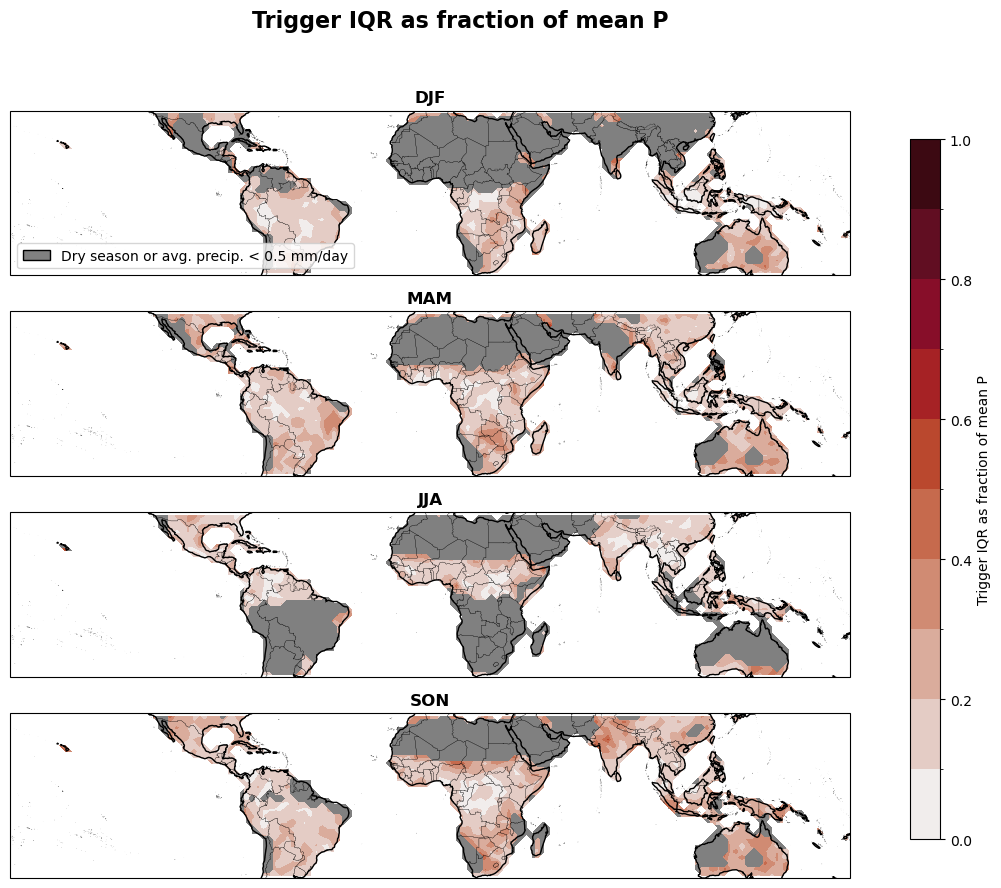

In [44]:
seas_thresh = 0.5 # mm/day

fig = plt.figure(figsize=(12,10))

var = 'triggiqr_cv_meanpr'

cbar_params = {'triggiqr':{'vmin':0,'vmax':5,'cmap':cmocean.cm.amp,'levels':11},
               'triggiqr_cv_log':{'vmin':-1,'vmax':1,'cmap':mpl.colormaps['berlin'],'levels':11},
               'triggiqr_cv_meanpr':{'vmin':0,'vmax':1,'cmap':cmocean.cm.amp,'levels':11}}

labels = {'triggiqr':'IQR of bootstrapped trigger thresholds [mm/day]',
          'triggiqr_cv_log':'IQR / Mean of bootstrapped trigger thresholds',
          'triggiqr_cv_meanpr':'Trigger IQR as fraction of mean P'}


subset_params = {'lat':slice(-35,35),'lon':slice(-180,180)}

for seas_idx,seas in enumerate(['DJF','MAM','JJA','SON']):
    ax = plt.subplot(4,1,seas_idx+1,projection=ccrs.PlateCarree())

    plot_data = threshs[var].sel(season=seas,**subset_params)
    # Subset to land only
    plot_data = plot_data.where(landmask)

    # Plot
    plot_data.plot.contourf(transform=ccrs.PlateCarree(),**cbar_params[var],
                            add_colorbar=False)

    # Grey out regions without an active rainy season or that are generally 
    # too dry
    season_mask = (active_seasons_rg.seasmask.sel(season=seas,**subset_params) & 
                   dry_thresh).where(landmask)
    season_mask.plot.contourf(levels=[-0.5, 0.5, 1.5],
                                 colors=['grey','none'],
                                 hatches=[None, None],
                                 transform=ccrs.PlateCarree(),
                                 add_colorbar=False)

    ax.coastlines()
    ax.set_title(seas,fontweight='bold',fontsize=12)
    
    # Country borders
    # Add to plot (subset_params in slice format)
    gdf.cx[subset_params['lon'],subset_params['lat']].plot(ax=ax,facecolor='none',edgecolor='k',
                                                       linestyle='-',linewidth=0.15,
                                                       transform=ccrs.PlateCarree())
    ax.set_extent([subset_params['lon'].start,
                   subset_params['lon'].stop,
                   subset_params['lat'].start,
                   subset_params['lat'].stop])

    if seas_idx == 0:
        ax.legend(handles=[mpatches.Patch(facecolor='grey',edgecolor='k',
                                          label=f'Dry season or avg. precip. < {str(seas_thresh)} mm/day')],loc='lower left')

fig.subplots_adjust(right=0.825)
cax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
levels = mpl.ticker.MaxNLocator(nbins=cbar_params[var]['levels']).tick_values(cbar_params[var]['vmin'],cbar_params[var]['vmax'])
norm = mpl.colors.BoundaryNorm(levels, ncolors=cbar_params[var]['cmap'].N, clip=True)
sm = plt.cm.ScalarMappable(cmap=cbar_params[var]['cmap'],norm=norm)
plt.colorbar(sm,cax=cax,label=labels[var])


plt.suptitle(labels[var],fontweight='bold',fontsize=16)

utility_print(dir_list['figs']+proc_source+'_maps')

## Decadal variability figure

In [53]:
#-------------------------
# Get var of decadal means
#-------------------------
# Load data
ds = load_data(proc_source)

dsm = ds.groupby(
    time=SeasonResampler(["DJF", "MAM", "JJA", "SON"], drop_incomplete=True)
).mean()

# Unstack into season x year
dsm['season'] = dsm.time.dt.season
dsm['year'] = dsm.time.dt.year
dsm = dsm.set_index(time=['season','year']).unstack()

# Get SD of 10-year-rolling-mean
decvar = dsm.pr.rolling(year=10).mean().std('year')

ERROR! Session/line number was not unique in database. History logging moved to new session 134
/home/kschwarz/projects/forecast_uncertainty/2. figures/GPCP_decvar_maps.pdf saved!
/home/kschwarz/projects/forecast_uncertainty/2. figures/GPCP_decvar_maps.png saved!


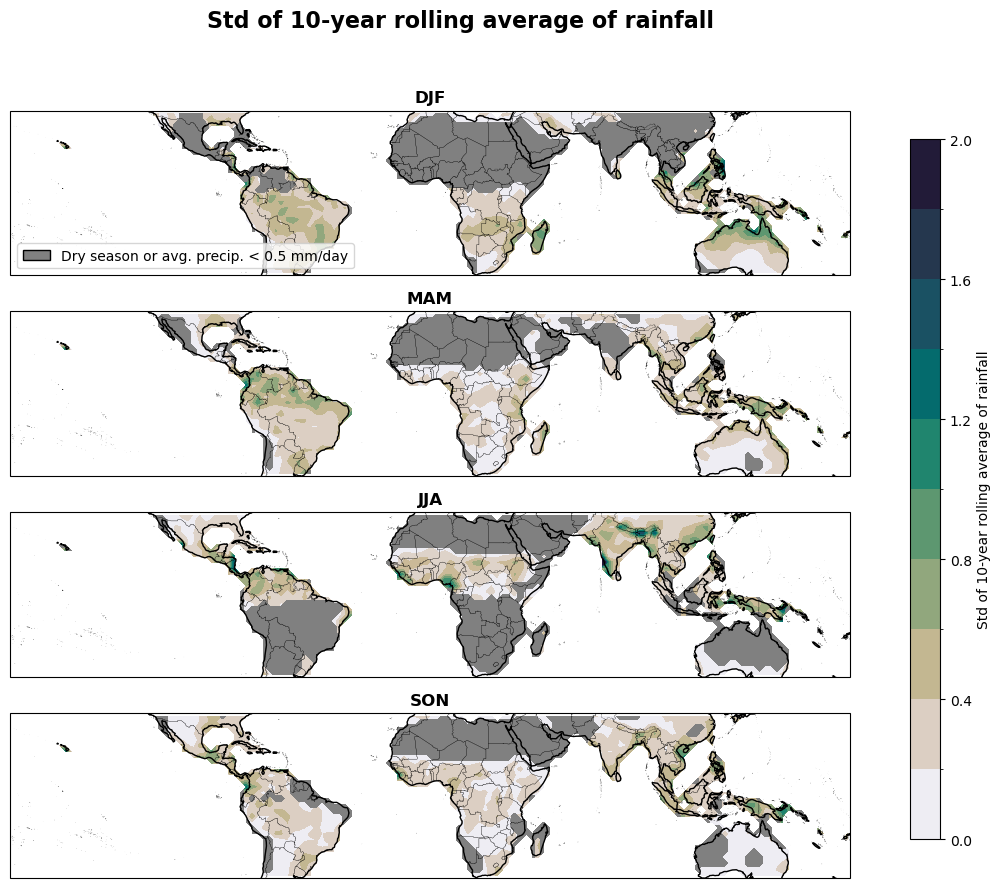

In [56]:
seas_thresh = 0.5 # mm/day

fig = plt.figure(figsize=(12,10))

subset_params = {'lat':slice(-35,35),'lon':slice(-180,180)}

var = 'decvar'
cbar_params = {'decvar':{'vmin':0,'vmax':2,'cmap':cmocean.cm.rain,'levels':11}}
labels = {'decvar':'Std of 10-year rolling average of rainfall'}

for seas_idx,seas in enumerate(['DJF','MAM','JJA','SON']):
    ax = plt.subplot(4,1,seas_idx+1,projection=ccrs.PlateCarree())

    plot_data = decvar.sel(season=seas,**subset_params)
    # Subset to land only
    plot_data = plot_data.where(landmask)

    # Plot
    plot_data.plot.contourf(transform=ccrs.PlateCarree(),**cbar_params[var],
                            add_colorbar=False)

    # Grey out regions without an active rainy season
    season_mask = (active_seasons_rg.seasmask.sel(season=seas,**subset_params) & 
                   dry_thresh).where(landmask)
    season_mask.sel(season=seas,**subset_params).where(landmask).plot.contourf(levels=[-0.5, 0.5, 1.5],
                                                                                     colors=['grey','none'],
                                                                                     hatches=[None, None],
                                                                                     transform=ccrs.PlateCarree(),
                                                                                     add_colorbar=False)

    ax.coastlines()
    ax.set_title(seas,fontweight='bold',fontsize=12)
    
    # Country borders
    # Add to plot (subset_params in slice format)
    gdf.cx[subset_params['lon'],subset_params['lat']].plot(ax=ax,facecolor='none',edgecolor='k',
                                                       linestyle='-',linewidth=0.15,
                                                       transform=ccrs.PlateCarree())
    ax.set_extent([subset_params['lon'].start,
                   subset_params['lon'].stop,
                   subset_params['lat'].start,
                   subset_params['lat'].stop])

    if seas_idx == 0:
        ax.legend(handles=[mpatches.Patch(facecolor='grey',edgecolor='k',
                                          label=f'Dry season or avg. precip. < {str(seas_thresh)} mm/day')],loc='lower left')

fig.subplots_adjust(right=0.825)
cax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
levels = mpl.ticker.MaxNLocator(nbins=cbar_params[var]['levels']).tick_values(cbar_params[var]['vmin'],cbar_params[var]['vmax'])
norm = mpl.colors.BoundaryNorm(levels, ncolors=cbar_params[var]['cmap'].N, clip=True)
sm = plt.cm.ScalarMappable(cmap=cbar_params[var]['cmap'],norm=norm)
plt.colorbar(sm,cax=cax,label=labels[var])


plt.suptitle(labels[var],fontweight='bold',fontsize=16)

utility_print(dir_list['figs']+proc_source+'_decvar_maps')